# Customer Churn Prediction

**In** this project, we use supervised learning models to identify customers who are likely to stop using service in the future. Furthermore, we will analyze top factors that influence user retention.

## Contents

<ul>
<li>[Part 1: Data Exploration](#Part-1:-Data-Exploration)
<li>[Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
<li>[Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
<li>[Part 4: Feature Selection](#Part-4:-Feature-Selection)
</ul>

# Part 0: Setup Google Drive Environment

In [0]:
# method 1 install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
link = 'https://drive.google.com/open?id=1JczT5KaTncUy0GabzoRAEfcvjFPQSYF2'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('churn.all')  

In [0]:
import pandas as pd

df1 = pd.read_csv('churn.all')
df1.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [0]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

churn_df = pd.read_csv('churn.all')

In [0]:
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [0]:
print ("Num of rows: " + str(churn_df.shape[0])) # row count
print ("Num of columns: " + str(churn_df.shape[1])) # col count

Num of rows: 5000
Num of columns: 21


### Part 1.2: Data cleaning

Remove Extra Whitespace

In [0]:
# check categorical feature
churn_df['voice_mail_plan'][0]

' yes'

In [0]:
# remove the heading and trailing whitespaces
churn_df['voice_mail_plan'] = churn_df['voice_mail_plan'].apply(lambda x: x.strip())
churn_df['intl_plan'] = churn_df['intl_plan'].apply(lambda x: x.strip())
churn_df['churned'] = churn_df['churned'].apply(lambda x: x.strip())

In [0]:
# check the categorical feature after manipulation
churn_df['voice_mail_plan'][0]

'yes'

### Part 1.3:  Understand the features

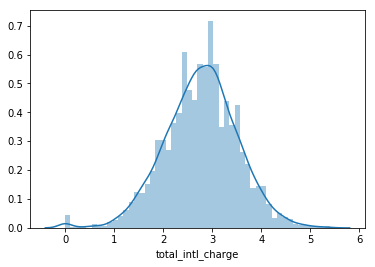

In [0]:
# check the feature distribution
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(churn_df['total_intl_charge'])

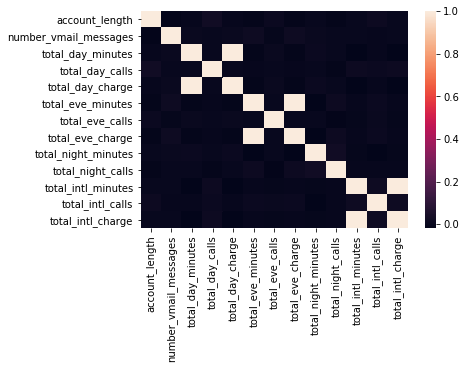

In [0]:
# correlations between all the features
corr = churn_df[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]].corr()

# show heapmap of correlations
sns.heatmap(corr)

In [0]:
# check the actual values of correlations
corr

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_intl_charge
account_length,1.000000,-0.014575,-0.001017,0.028240,-0.001019,-0.009591,0.009143,-0.009587,0.000668,-0.007825,0.001291,0.014277,0.001292
number_vmail_messages,-0.014575,1.000000,0.005381,0.000883,0.005377,0.019490,-0.003954,0.019496,0.005541,0.002676,0.002463,0.000124,0.002505
total_day_minutes,-0.001017,0.005381,1.000000,0.001935,1.000000,-0.010750,0.008128,-0.010760,0.011799,0.004236,-0.019486,-0.001303,-0.019415
total_day_calls,0.028240,0.000883,0.001935,1.000000,0.001936,-0.000699,0.003754,-0.000695,0.002804,-0.008308,0.013097,0.010893,0.013161
total_day_charge,-0.001019,0.005377,1.000000,0.001936,1.000000,-0.010747,0.008129,-0.010757,0.011801,0.004235,-0.019490,-0.001307,-0.019419
total_eve_minutes,-0.009591,0.019490,-0.010750,-0.000699,-0.010747,1.000000,0.002763,1.000000,-0.016639,0.013420,0.000137,0.008388,0.000159
total_eve_calls,0.009143,-0.003954,0.008128,0.003754,0.008129,0.002763,1.000000,0.002778,0.001781,-0.013682,-0.007458,0.005574,-0.007507
total_eve_charge,-0.009587,0.019496,-0.010760,-0.000695,-0.010757,1.000000,0.002778,1.000000,-0.016649,0.013422,0.000132,0.008393,0.000155
total_night_minutes,0.000668,0.005541,0.011799,0.002804,0.011801,-0.016639,0.001781,-0.016649,1.000000,0.026972,-0.006721,-0.017214,-0.006655
total_night_calls,-0.007825,0.002676,0.004236,-0.008308,0.004235,0.013420,-0.013682,0.013422,0.026972,1.000000,0.000391,-0.000156,0.000368


# Part 2: Feature Preprocessing

In [0]:
# calculate two features correlation
from scipy.stats import pearsonr
print (pearsonr(churn_df['total_day_minutes'], churn_df['number_vmail_messages'])[0])

0.00538137596065452


In [0]:
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [0]:
# Get ground truth data
y = np.where(churn_df['churned'] == 'True.',1,0)

# Drop some useless columns
to_drop = ['state','area_code','phone_number','churned']
churn_feat_space = churn_df.drop(to_drop, axis=1)

# yes and no have to be converted to boolean values
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

X = churn_feat_space

In [0]:
# check the propotion of y = 1
print(y.sum() / y.shape * 100)

[14.14]


# Part 3: Model Training and Result Evaluation

### Part 3.1: Split dataset

In [0]:
# Splite data into training and testing
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 4000 observation with 17 features
test data has 1000 observation with 17 features


In [0]:
# Scale the data, using standardization
# standardization (x-mean)/std
# normalization (x-x_min)/(x_max-x_min)
# 1. speed up gradient descent
# 2. same scale

# for example, use training data to train the standardscaler to get mean and std 
# apply mean and std to both training and testing data.
# fit_transform does the training and applying, transform only does applying.
# Because we can't use any info from test, and we need to do the same modification
# to testing data as well as training data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Part 3.2: Model Training and Selection

In [0]:
#@title build models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

In [0]:
# Train the model
classifier_logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Prediction of test data
classifier_logistic.predict(X_test)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [0]:
# Accuracy of test data
classifier_logistic.score(X_test, y_test)

0.857

In [0]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','KNN','Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5)
    print(cv_score)
    print('Model accuracy of %s is: %.3f'%(model_names[count],cv_score.mean()))
    count += 1

[0.85892634 0.87375    0.8725     0.865      0.8698373 ]
Model accuracy of Logistic Regression is: 0.868
[0.88764045 0.8975     0.89375    0.89125    0.88986233]
Model accuracy of KNN is: 0.892
[0.94132335 0.9475     0.965      0.9525     0.95369212]
Model accuracy of Random Forest is: 0.952


### Part 3.3: Use Grid Search to Find Optimal Hyperparameters

In [0]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

#### Part 3.3.1: Find Optimal Hyperparameters - LogisticRegression

In [0]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

# ('l1', 1) ('l1', 5), ('l1', 10) ('l2', 1) ('l2', 5), ('l2', 10)
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': (1, 5, 10), 'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.868
Best parameters set:
	C: 1
	penalty: 'l2'


In [0]:
# best model
best_LR_model = Grid_LR.best_estimator_

#### Part 3.3.2: Find Optimal Hyperparameters: KNN

In [0]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None, param_grid={'n_neighbors': [3, 5, 7, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
# best k
print_grid_search_metrics(Grid_KNN)

Best score: 0.894
Best parameters set:
	n_neighbors: 3


#### Part 3.3.3: Find Optimal Hyperparameters: Random Forest

In [0]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [40,60,80]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [0]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.960
Best parameters set:
	n_estimators: 80


In [0]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

### Part 3.4: Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

class of interest as positive

TP: correctly labeled real churn

Precision(PPV, positive predictive value): tp / (tp + fp);
Total number of true predictive churn divided by the total number of predictive churn;
High Precision means low fp, not many return users were predicted as churn users. 


Recall(sensitivity, hit rate, true positive rate): tp / (tp + fn)
Predict most postive or churn user correctly. High recall means low fn, not many churn users were predicted as return users.

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.953
precision is: 0.947
recall is: 0.723


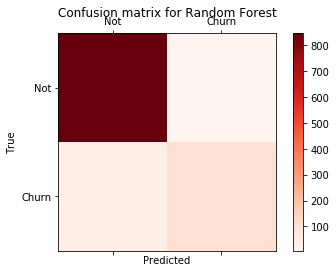

Logistic Regression
Accuracy is: 0.857
precision is: 0.564
recall is: 0.149


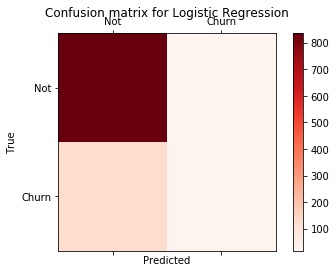

In [0]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
]

draw_confusion_matrices(confusion_matrices)

### Part 3.4: Model Evaluation - ROC & AUC

RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function 

#### Part 3.4.1: ROC of RF Model

In [0]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

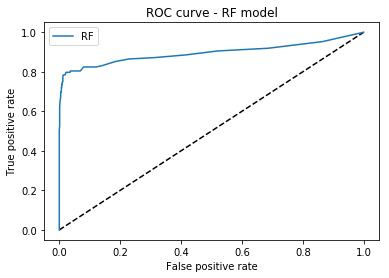

In [0]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [0]:
from sklearn import metrics

# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.89516717421647

#### Part 3.4.1: ROC of LR Model

In [0]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

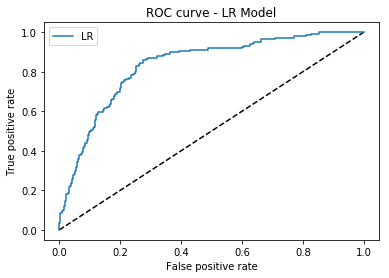

In [0]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [0]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.833531594975257

# Part 4: Feature Selection

### Part 4.1:  Logistic Regression Model - Feature Selection Discussion 

The corelated features that we are interested in: (total_day_minutes, total_day_charge), (total_eve_minutes, total_eve_charge), (total_intl_minutes, total_intl_charge).

In [0]:
# add L1 regularization to logistic regression
# check the coef for feature selection
scaler = StandardScaler()
X_l1 = scaler.fit_transform(X)
LRmodel_l1 = LogisticRegression(penalty="l1", C = 0.1)
LRmodel_l1.fit(X_l1, y)
LRmodel_l1.coef_[0]
print ("Logistic Regression (L1) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]), \
                      churn_feat_space.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))

Logistic Regression (L1) Coefficients
number_customer_service_calls: 0.6379
intl_plan: 0.5866
total_day_charge: 0.4828
voice_mail_plan: -0.4333
total_day_minutes: 0.209
total_eve_minutes: 0.1967
total_intl_charge: 0.1784
total_intl_calls: -0.147
total_eve_charge: 0.1267
total_night_charge: 0.1078
total_night_minutes: 0.0657
total_intl_minutes: 0.0355
account_length: 0.0352
total_day_calls: 0.0301
total_night_calls: -0.011
total_eve_calls: -0.0091
number_vmail_messages: 0.0


In [0]:
# add L2 regularization to logistic regression
# check the coef for feature selection
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X)
LRmodel_l2 = LogisticRegression(penalty="l2", C = 0.1)
LRmodel_l2.fit(X_l2, y)
LRmodel_l2.coef_[0]
print ("Logistic Regression (L2) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l2.coef_[0]), \
                      churn_feat_space.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
  

Logistic Regression (L2) Coefficients
number_customer_service_calls: 0.6404
voice_mail_plan: -0.5974
intl_plan: 0.5895
total_day_minutes: 0.3502
total_day_charge: 0.3495
total_eve_charge: 0.1701
total_eve_minutes: 0.1699
total_intl_calls: -0.1653
number_vmail_messages: 0.1619
total_intl_charge: 0.1161
total_intl_minutes: 0.1156
total_night_minutes: 0.0962
total_night_charge: 0.0956
account_length: 0.0533
total_day_calls: 0.0483
total_night_calls: -0.0302
total_eve_calls: -0.0289


### Part 4.2:  Random Forest Model - Feature Importance Discussion

In [0]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), churn_feat_space.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
total_day_charge: 0.1551
total_day_minutes: 0.1303
number_customer_service_calls: 0.1179
intl_plan: 0.0773
total_eve_charge: 0.071
total_eve_minutes: 0.0707
total_intl_calls: 0.0599
total_night_minutes: 0.0473
total_intl_minutes: 0.0399
total_intl_charge: 0.0368
total_night_charge: 0.0352
account_length: 0.0323
total_night_calls: 0.0309
number_vmail_messages: 0.0259
total_eve_calls: 0.0252
total_day_calls: 0.0222
voice_mail_plan: 0.0218
